In [1]:
pip install -r requirements.txt

ERROR: Cannot uninstall 'entrypoints'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.



  Using cached entrypoints-0.4-py3-none-any.whl (5.3 kB)
  Using cached executing-1.2.0-py2.py3-none-any.whl (24 kB)
  Using cached fonttools-4.38.0-py3-none-any.whl (965 kB)
  Using cached huggingface_hub-0.11.1-py3-none-any.whl (182 kB)
  Using cached ipykernel-6.20.1-py3-none-any.whl (149 kB)
  Using cached ipython-8.8.0-py3-none-any.whl (775 kB)
  Using cached jedi-0.18.2-py2.py3-none-any.whl (1.6 MB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached jupyter_client-7.4.8-py3-none-any.whl (133 kB)
  Using cached jupyter_core-5.1.3-py3-none-any.whl (93 kB)
  Using cached kiwisolver-1.4.4-cp38-cp38-win_amd64.whl (55 kB)
  Using cached matplotlib-3.6.3-cp38-cp38-win_amd64.whl (7.2 MB)
  Using cached matplotlib_inline-0.1.6-py3-none-any.whl (9.4 kB)
  Using cached nest_asyncio-1.5.6-py3-none-any.whl (5.2 kB)
  Using cached numpy-1.24.1-cp38-cp38-win_amd64.whl (14.9 MB)
Processing c:\users\user\appdata\local\pip\cache\wheels\2f\9c\55\95d3609ccfc463eeffb96d50c756f1f189

In [2]:
#import libraries
import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import os
import pandas as pd
import tiktoken
import openai
import numpy as np
from openai.embeddings_utils import distances_from_embeddings

C:\Users\user\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [4]:
# Regex pattern to match a URL
HTTP_URL_PATTERN = r'^http[s]*://.+'

domain = "www.sheneller.com" # <- domain to be crawled
full_url = "https://www.sheneller.com/post/the-traditional-sri-lankan-wellness-village-experience-ulpotha-retreat" # <- domain to be crawled with https or http

def crawl(url):
    # Parse the URL and get the domain
    local_domain = urlparse(url).netloc

    # Create a directory to store the text files
    if not os.path.exists("text/"):
            os.mkdir("text/")

    if not os.path.exists("text/"+local_domain+"/"):
            os.mkdir("text/" + local_domain + "/")

    # Create a directory to store the csv files
    if not os.path.exists("processed"):
            os.mkdir("processed")

    # Save text from the url to a <url>.txt file
    with open('text/'+local_domain+'/'+url[8:].replace("/", "_") + ".txt", "w", encoding="UTF-8") as f:

        # Get the text from the URL using BeautifulSoup
        soup = BeautifulSoup(requests.get(url).text, "html.parser")

        # Get the text but remove the tags
        text = soup.get_text()

        # If the crawler gets to a page that requires JavaScript, it will stop the crawl
        if ("You need to enable JavaScript to run this app." in text):
            print("Unable to parse page " + url + " due to JavaScript being required")
            
        # Otherwise, write the text to the file in the text directory
        f.write(text)

crawl(full_url)

In [5]:
#Remove blank empty lines
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [6]:
# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
for file in os.listdir("text/" + domain + "/"):

    # Open the file and read the text
    with open("text/" + domain + "/" + file, "r", encoding="UTF-8") as f:
        text = f.read()

        # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
        texts.append((file[11:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed/scraped.csv')
df.head()

,fname,text
0,er.com post the traditional sri lankan wellnes...,er.com post the traditional sri lankan wellnes...


<AxesSubplot:>

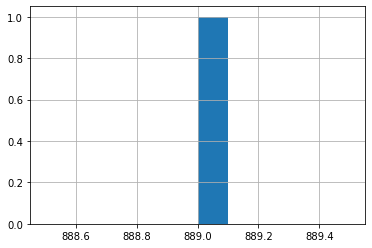

In [7]:
# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [8]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks
    

shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

<AxesSubplot:>

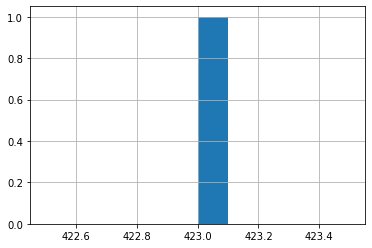

In [9]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [10]:
# import openai
openai.api_key = "<API-KEY>"

#create embeddings
df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])

df.to_csv('processed/embeddings.csv')
df.head()

,text,n_tokens,embeddings
0,er.com post the traditional sri lankan wellnes...,423,"[0.012547806836664677, 0.013542787171900272, 0..."


In [11]:
#Turn embeddings into a Numpy array
df=pd.read_csv('processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()

,text,n_tokens,embeddings
0,er.com post the traditional sri lankan wellnes...,423,"[0.012547806836664677, 0.013542787171900272, 0..."


In [12]:
def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if cur_len > max_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

In [19]:
def answer_question(
    df,
    model="text-davinci-003",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

In [23]:
answer_question(df, question="Hi!")

'Hi!'

In [20]:
answer_question(df, question="What is Ulpotha retreat?")

'Ulpotha retreat is a private secret hideaway modeled after a traditional Sri Lankan village, with clay homes and communal spaces built in nature. It offers yoga retreats, massages, therapies, and Ayurvedic treatments, immersing guests in the lifestyle of an authentic Sri Lankan village as it would have been a century ago.'

In [21]:
answer_question(df, question="What day is it?")

"I don't know."

In [22]:
answer_question(df, question="Where is Ulpotha located in Sri Lanka?")

'Ulpotha is located in the north-central region of Sri Lanka, within the Cultural Triangle.'

In [24]:
answer_question(df, question="Thank You!")

"You're welcome!"